# 06_plot_ISC_figure

In [8]:
import numpy as np
from os.path import join as pjoin
from os.path import isdir
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mne_bids
import mne
from mne_bids import write_raw_bids, BIDSPath
from scipy import stats
import re
from scipy import signal
import pandas as pd
from scipy import signal, fftpack
from PIL import Image

In [2]:
# define variables
sub_list = ['{0:0>2d}'.format(sub) for sub in np.arange(1,12)]
run_list = ['{0:0>2d}'.format(run) for run in np.arange(1,9)]
band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# set path
pre_root = '/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids'
post_root = pjoin(pre_root, 'derivatives', 'preproc_meg-mne_mri-fmriprep')
results_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results/'


In [3]:
def plot_topomap(val, meg_layout, title=None):
    """
    input params: val: [n_chn(272), 1]
                  meg_layout: mne Layout instance
                  title: str, title for plot, default to None
    """
    
    pos = meg_layout.pos[:,:2]
    x_min = np.min(pos[:,0])
    x_max = np.max(pos[:,0])
    y_min = np.min(pos[:,1])
    y_max = np.max(pos[:,1])
    center_x = (x_min + x_max)/2
    center_y = (y_min + y_max)/2
    layout_pos = np.zeros(pos.shape)
    for i, coor in enumerate(pos):
        layout_pos[i,0] = coor[0] - center_x
        layout_pos[i,1] = coor[1] - center_y
        
    fig = plt.figure()
    if title is not None:
        plt.title(title)
    norm = colors.Normalize(vmin=np.min(val), vmax=np.max(val))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'))
    mne.viz.plot_topomap(val, layout_pos, cmap='viridis', sphere=np.array([0,0,0,0.5]))
    
    return fig

In [4]:
# load data
bandISC_pre = pd.read_pickle(pjoin(results_pth, 'bandISC_pre.pickle'))
bandISC_post = pd.read_pickle(pjoin(results_pth, 'bandISC_post.pickle'))

In [5]:
# extract layout
sub_path = BIDSPath(subject='01', run='01', task='movie', session='movie', root='/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids')
raw_sub = mne_bids.read_raw_bids(sub_path)
meg_layout = mne.channels.find_layout(raw_sub.info, ch_type='meg')
intercorr_chn = []
ch_name_picks = mne.pick_channels_regexp(raw_sub.ch_names, regexp='M[LRZ]...-4503')
type_picks = mne.pick_types(raw_sub.info, meg=True)
picks= np.intersect1d(ch_name_picks, type_picks)
for idx in picks:
    intercorr_chn.append(raw_sub.ch_names[idx][:5])
exclude_list = [x for x in meg_layout.names if x not in intercorr_chn]
meg_layout = mne.channels.find_layout(raw_sub.info, ch_type='meg', exclude=exclude_list)


ds directory : /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       4.65   74.88    0.00 mm <->    4.65   74.88    0.00 mm (orig :  -65.68   46.24 -249.17 mm) diff =    0.000 mm
      -4.65  -74.88    0.00 mm <->   -4.65  -74.88    0.00 mm (orig :   42.00  -58.24 -250.44 mm) diff =    0.000 mm
      92.94    0.00    0.00 mm <->   92.94   -0.00    0.00 mm (orig :   46.46   62.07 -225.18 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds/sub-01_ses-movie_task-movie_run-01_meg.meg4: 
    System clock channel is availabl

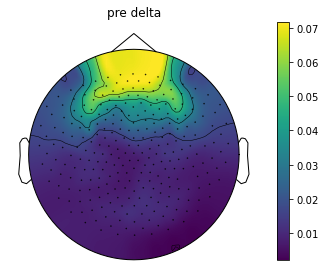

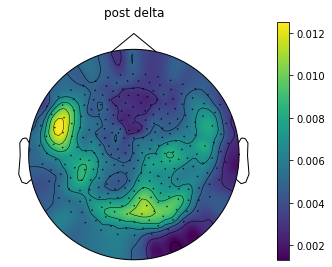

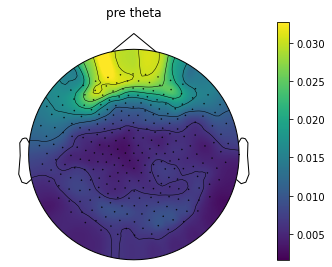

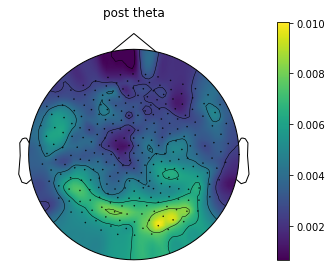

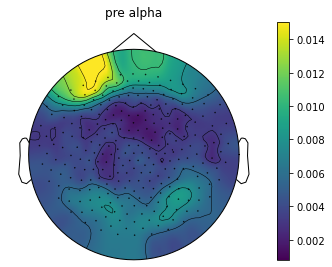

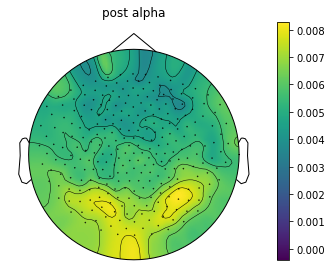

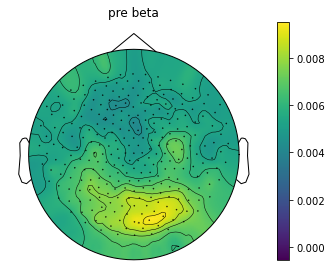

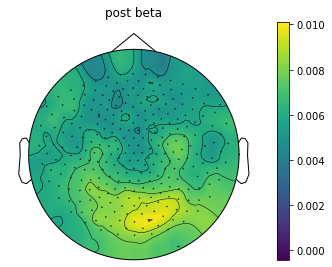

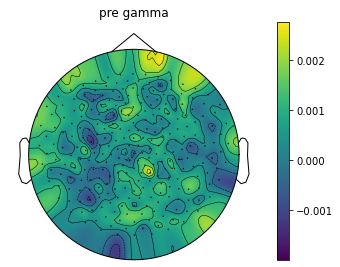

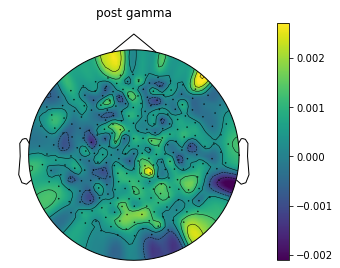

In [12]:
bandISC_dir = pjoin(results_pth, 'bandISC')
if os.path.exists(bandISC_dir) is False:
    os.mkdir(bandISC_dir)

for band in band_names:
    fig = plot_topomap(np.mean(np.mean(np.mean(bandISC_pre[band], axis=1), axis=1),axis=0), meg_layout, title=f'pre {band}')
    fig.savefig(pjoin(bandISC_dir, f'pre {band}.png'))
    fig = plot_topomap(np.mean(np.mean(np.mean(bandISC_post[band], axis=1), axis=1),axis=0), meg_layout, title=f'post {band}')
    fig.savefig(pjoin(bandISC_dir, f'post {band}.png'))

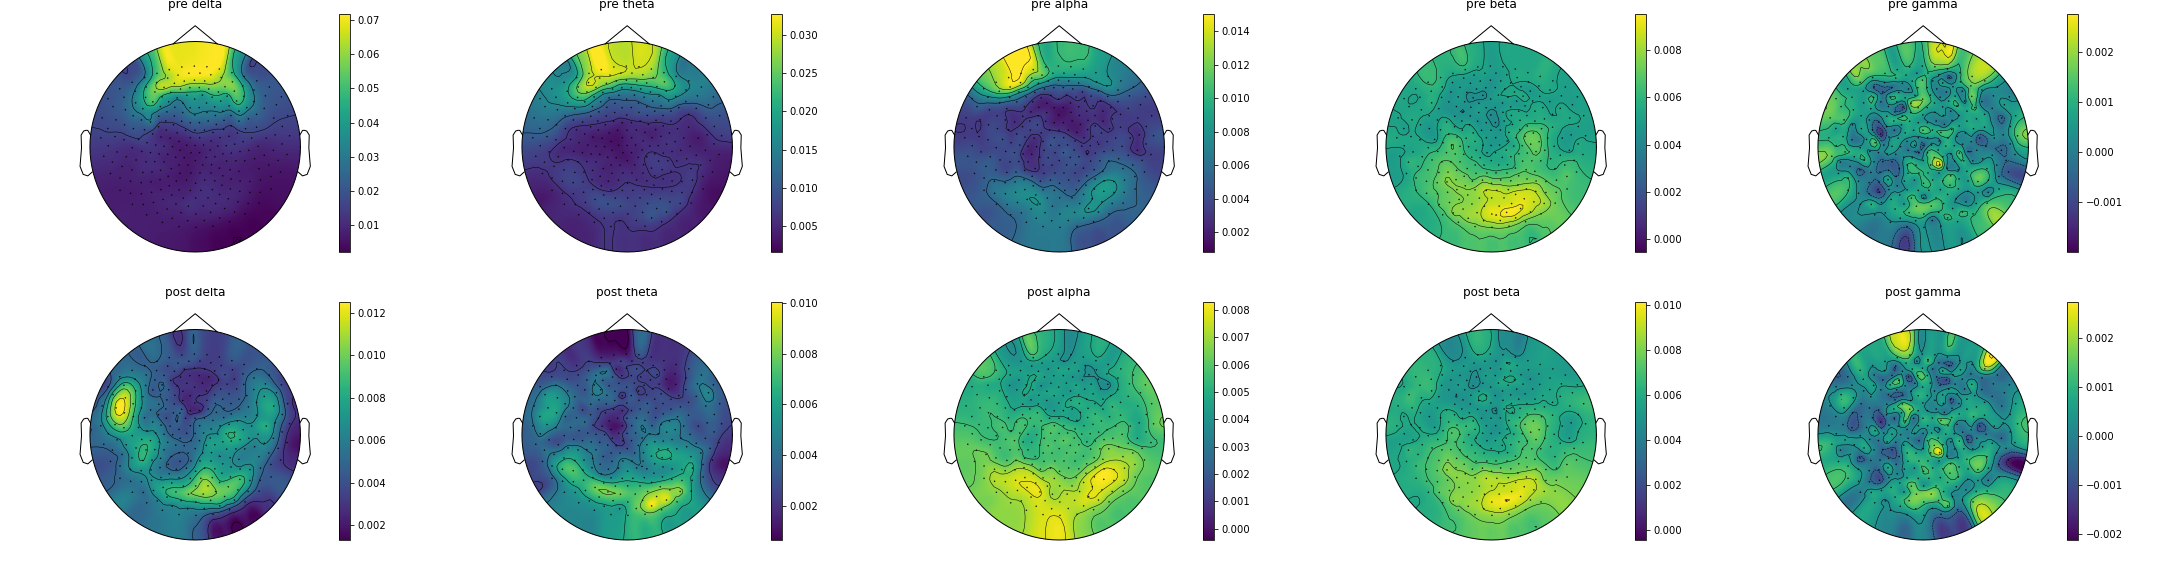

In [13]:
# integrate to 1 figure
pre_img_list = []
post_img_list = []
for band_n in band_names:
    pre_img_list.append(Image.open(pjoin(bandISC_dir, f'pre {band_n}.png')))
    post_img_list.append(Image.open(pjoin(bandISC_dir, f'post {band_n}.png')))
    
width, height = pre_img_list[0].size
full_img = Image.new(pre_img_list[0].mode, (width*5, height*2), (255,255,255))
for i in np.arange(5):
    full_img.paste(pre_img_list[i], box=(width*i, 0))
    full_img.paste(post_img_list[i], box=(width*i, height))
full_img.save(pjoin(bandISC_dir, 'total_bandISC.png'))
full_img